In [1]:
import pandas as pd
import numpy as np, warnings
from pathlib import Path
import os
import sys
# import sweetviz as sv
from importlib import reload
import matplotlib.pyplot as plt
import seaborn as sns
import timeshap as ts
from timeshap import __version__
__version__

np.warnings = warnings

ROOT_DIR = Path('..')
sys.path.append(os.path.abspath(os.path.join('../Kha Huynh/Data cleansing')))
import DataLoader as DataLoader
reload(DataLoader)

dataLoader = DataLoader.DataLoader(ROOT_DIR)

import model_evaluation as me
reload(me)

<module 'model_evaluation' from 'd:\\Kha\\UWA\\CITS5553\\sepsis_prediction\\data-science-capstone-project\\Kha Huynh\\Data cleansing\\model_evaluation.py'>

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_validate, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_selection import SelectFromModel

# model comparison
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier,AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
# from xgboost import XGBClassifier

# evaluation metrics
from sklearn.metrics import cohen_kappa_score,classification_report
from sklearn.metrics import mean_squared_error, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score, auc, make_scorer
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, balanced_accuracy_score
from sklearn.metrics import PrecisionRecallDisplay
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import balanced_accuracy_score
from keras.utils import to_categorical

import tensorflow as tf

# Data Preparation

In [92]:
# t0_df = pd.read_csv(df_final)
path_df = ROOT_DIR / 'data/Model input data/t4_nan.csv'
df_data = pd.read_csv(path_df)# t0_df

admission = df_data[['SUBJECT_ID', 'HADM_ID', 'IS_SEPSIS']].drop_duplicates(["SUBJECT_ID", "HADM_ID"])

x_train_df, x_test_df, _, _ = train_test_split(
    admission.drop('IS_SEPSIS', axis=1),  # dropping the target column for X values
    admission['IS_SEPSIS'],
    test_size=0.2,  # this means 20% test set
    stratify=admission['IS_SEPSIS'],  # stratify by the target variable
    random_state=42  # to ensure reproducibility
)
x_train_df = df_data.merge(x_train_df[['SUBJECT_ID', 'HADM_ID']])
x_train_df['count'] = x_train_df.groupby(['SUBJECT_ID', 'HADM_ID'])['HADM_ID'].transform('count')
x_train_count = x_train_df.drop_duplicates(['SUBJECT_ID', 'HADM_ID'])['count']
y_train_df = x_train_df.drop_duplicates(['SUBJECT_ID', 'HADM_ID'])['IS_SEPSIS']

x_test_df = df_data.merge(x_test_df[['SUBJECT_ID', 'HADM_ID']])
x_test_df['count'] = x_test_df.groupby(['SUBJECT_ID', 'HADM_ID'])['HADM_ID'].transform('count')
x_test_count = x_test_df.drop_duplicates(['SUBJECT_ID', 'HADM_ID'])['count']
y_test_df = x_test_df.drop_duplicates(['SUBJECT_ID', 'HADM_ID'])['IS_SEPSIS']

In [93]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean', missing_values=np.nan)

train_gendernum = x_train_df.GENDER_NUM.values #take out the column doesn't need to scale
test_gendernum = x_test_df.GENDER_NUM.values

# impute X
x_train = imputer.fit_transform(x_train_df.drop(["SUBJECT_ID", "HADM_ID", 'IS_SEPSIS', 'CHARTTIME', 'count', 'GENDER_NUM'], axis=1))
x_test = imputer.transform(x_test_df.drop(["SUBJECT_ID", "HADM_ID", 'IS_SEPSIS', 'CHARTTIME', 'count', 'GENDER_NUM'], axis=1))

In [94]:
# Feature scaling - Standardisation
scaler = StandardScaler()

x_train = scaler.fit_transform(x_train) #scale X
x_test = scaler.transform(x_test)

x_train = np.column_stack((x_train, train_gendernum)) #merge the columns doesn't need to scale back to X
x_test = np.column_stack((x_test, test_gendernum))

In [95]:
def ts_to_secs(X, X_count, Y):
    secs_data = []

    k=0
    for i in X_count:
        secs_data.append(X[k:k+i, :])
        k = k+i

    secs_data = tf.ragged.constant(secs_data)

    # act_secs_labels = Y.values
    # act_secs_labels = np.array(act_secs_labels)
    act_secs_labels = to_categorical(Y)
    return secs_data, act_secs_labels


In [96]:
def data_preparation():
  train_data, act_train = ts_to_secs(x_train, x_train_count, y_train_df)
  test_data, act_test = ts_to_secs(x_test, x_test_count, y_test_df)

  # Here we add an extra dimension to the datasets just to be ready for using with Convolution2D
  print("[INFO] -- Shape of Training Sections:")
  print(train_data.bounding_shape())
  print("[INFO] -- Shape of Test Sections:")
  print(test_data.bounding_shape())

  return train_data, act_train, test_data, act_test

In [97]:
x_train, y_train, x_test, y_test = data_preparation()

[INFO] -- Shape of Training Sections:
tf.Tensor([36629    13    22], shape=(3,), dtype=int64)
[INFO] -- Shape of Test Sections:
tf.Tensor([9158   13   22], shape=(3,), dtype=int64)


# Shiv's Training

In [63]:
from keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import LSTM, Embedding, Input, MaxPooling2D
from keras.models import Sequential, Model
from sklearn.model_selection import  train_test_split
import time
import keras
import numpy as np
# from keras.layers.convolutional import Conv1D
from keras.models import Sequential

In [64]:
inp = Input(shape=[32*9])
out = Dense(65)(inp)
#out = BatchNormalization()(out)
out_enc = Dense(64,activation='sigmoid')(out)
out = Dense(32*9)(out_enc)
model_enc = Model(inp, out_enc)
model = Model(inp,out)
model.compile(loss='mse',optimizer='adam')

In [66]:
model.fit(train_data.reshape([train_data.shape[0],9*32]),train_data.reshape([train_data.shape[0],9*32]),
epochs=10,batch_size=64)

AttributeError: 'RaggedTensor' object has no attribute 'reshape'

In [187]:
Xrand = model_enc.predict(Xtrain.reshape([Xtrain.shape[0],9*32]))

1155/1155 [==============================] - 1s 836us/step


In [188]:
Xrand_test = model_enc.predict(Xtest.reshape([Xtest.shape[0],9*32]))

289/289 [==============================] - 0s 891us/step


In [224]:
from tensorflow.keras.layers import Conv1D, MaxPool1D
inp = Input(shape=[9*32,1])
out = inp

for ix in range(3):
  out = Conv1D(64,3,activation='relu')(inp)
  out = MaxPool1D(2)(out)
  out = BatchNormalization()(out)

out = Flatten()(out)
for ix in range(3):
  out = Dense(32,activation='relu')(out)

out = Dense(1,activation='sigmoid')(out)
model = Model(inp,out)
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])

In [225]:
Xtrain.reshape([Xtrain.shape[0],9*32,1]).shape,y_train[:,1].numpy().shape

((36932, 288, 1), (36932,))

In [233]:
model.fit(Xtrain.reshape([Xtrain.shape[0],9*32,1]), y_train[:,1].numpy(), epochs=10, batch_size=64, sample_weight=sample_weights,validation_split=0.1)

Epoch 1/10
520/520 [==============================] - 9s 17ms/step - loss: 0.6351 - accuracy: 0.6633 - val_loss: 0.7682 - val_accuracy: 0.4042
Epoch 2/10
520/520 [==============================] - 9s 17ms/step - loss: 0.6266 - accuracy: 0.4671 - val_loss: 0.8590 - val_accuracy: 0.4792
Epoch 3/10
520/520 [==============================] - 11s 21ms/step - loss: 0.6263 - accuracy: 0.4736 - val_loss: 0.8526 - val_accuracy: 0.5119
Epoch 4/10
520/520 [==============================] - 11s 21ms/step - loss: 0.6170 - accuracy: 0.4752 - val_loss: 0.8692 - val_accuracy: 0.3855
Epoch 5/10
520/520 [==============================] - 11s 22ms/step - loss: 0.6141 - accuracy: 0.4879 - val_loss: 0.8877 - val_accuracy: 0.4513
Epoch 6/10
520/520 [==============================] - 11s 22ms/step - loss: 0.6159 - accuracy: 0.4616 - val_loss: 0.8501 - val_accuracy: 0.4399
Epoch 7/10
520/520 [==============================] - 11s 21ms/step - loss: 0.6106 - accuracy: 0.4847 - val_loss: 0.8977 - val_accuracy: 0

In [234]:
model.evaluate(Xtest.reshape([Xtest.shape[0],9*32,1]),y_test[:,1].numpy(),sample_weight=sample_weights_test)

289/289 [==============================] - 1s 3ms/step - loss: 2603.2422 - accuracy: 0.8761


[2603.2421875, 0.8760966062545776]

In [199]:

clf = RandomForestClassifier(max_depth=7)
clf.fit(Xrand,y_train.numpy()[:,1].astype(int),sample_weight=sample_weights)

RandomForestClassifier(max_depth=7)

In [200]:
balanced_accuracy_score(clf.predict(Xrand),y_train.numpy()[:,1].astype(int),
sample_weight=sample_weights)

0.6794695701424145

In [201]:
balanced_accuracy_score(clf.predict(Xrand_test),y_test.numpy()[:,1].astype(int),
sample_weight=sample_weights_test)

0.24996965282833777

In [128]:
balanced_accuracy_score(clf.predict(Xtest.reshape([Xtest.shape[0],9*32])),y_test.numpy()[:,1].astype(int),
sample_weight=sample_weights_test)

d:\Kha\UWA\CITS5553\sepsis_prediction\data-science-capstone-project\.venv\lib\site-packages\sklearn\metrics\_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


0.49999999999996275

In [129]:
clf.predict(Xtest.reshape([Xtest.shape[0],9*32])).sum()

0

In [120]:
confusion_matrix(clf.predict(Xtest.reshape([Xtest.shape[0],9*32])),y_test.numpy()[:,1].astype(int))

array([[8239,  993],
       [   0,    1]], dtype=int64)

In [109]:
clf.score(Xtrain.reshape([Xtrain.shape[0],9*32]),y_train.numpy()[:,1].astype(int),sample_weight=sample_weights)

0.8923573112701273

In [98]:
clf.score(Xtest.reshape([Xtest.shape[0],9*32]),y_test.numpy()[:,1].astype(int),sample_weight=sample_weights_test)

0.500217105521831

In [166]:
Xtest

array([[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  1.38939380e-01, -9.99000000e+02, ...,
         -5.72384029e-01,  9.65391033e-01, -6.15022139e-01]],

       [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e

In [16]:
from tensorflow.keras.layers import Input,LSTM,GRU,Dropout,BatchNormalization,Dense,TimeDistributed, Masking, Flatten, Bidirectional
from tensorflow.keras.models import Model

In [156]:
inp = Input(shape=[9,32])
out = Masking(mask_value=-999.0)(inp)
#out = Bidirectional(GRU(64, return_sequences=True,activation='swish'))(out)
#out = TimeDistributed(Dense(64,activation='relu'))(out)
out = Bidirectional(GRU(64,activation='swish'))(out)
out = Dense(1,activation='sigmoid')(out)
model = Model(inp, out)

In [17]:
from sklearn.impute import SimpleImputer

In [84]:
model.predict(np.random.random([1,9,32]))

NameError: name 'model' is not defined

In [87]:
columns_to_impute = [ix for ix in train_data_df.columns if 'ITEM' in ix]

In [88]:
imputer = SimpleImputer(strategy='mean', missing_values=-999)

In [89]:
imputer.fit(train_data_df[columns_to_impute])
train_data_df[columns_to_impute] = imputer.transform(train_data_df[columns_to_impute])

In [90]:
train_data_df

,SUBJECT_ID,HADM_ID,AGE,GENDER_NUM,IS_SEPSIS,ITEMID_50804,ITEMID_50813,ITEMID_50818,ITEMID_50820,ITEMID_50821,...,ITEMID_51244,ITEMID_51248,ITEMID_51256,ITEMID_51265,ITEMID_51274,ITEMID_51275,ITEMID_51277,ITEMID_51279,ITEMID_51301,ITEMID_51493
0,3,145834,76,0,0,23.000000,4.300000,40.000000,7.350000,20.000000,...,8.000000,29.100000,81.000000,282.000000,13.500000,30.700000,15.10000,3.440000,12.700000,12.058957
1,3,145834,76,0,0,28.000000,8.800000,28.000000,7.590000,313.000000,...,14.921071,28.900000,76.528675,190.000000,15.700000,58.300000,15.00000,2.700000,11.300000,12.058957
2,3,145834,76,0,0,13.000000,8.000000,28.000000,7.260000,329.000000,...,14.921071,29.600000,76.528675,253.000000,15.600000,46.400000,15.30000,2.790000,19.100000,12.058957
3,4,185777,47,1,0,25.149756,2.740949,43.919452,7.349502,242.033509,...,6.900000,30.400000,89.600000,207.000000,12.300000,31.300000,13.60000,3.800000,9.700000,12.058957
4,9,150750,41,0,0,25.149756,2.740949,43.919452,7.349502,242.033509,...,41.600000,28.300000,50.100000,258.000000,12.700000,21.700000,13.40000,5.460000,7.500000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53432,99983,117390,78,0,0,25.149756,2.740949,43.919452,7.349502,242.033509,...,14.921071,32.300000,76.528675,253.000000,13.400000,27.000000,12.70000,4.210000,7.500000,12.058957
53433,99995,137810,88,1,0,33.000000,1.100000,33.000000,7.590000,376.000000,...,14.921071,30.237789,76.528675,249.438695,19.700000,35.500000,14.95155,3.911541,11.898176,12.058957
53434,99995,137810,88,1,0,36.000000,1.100000,52.000000,7.430000,382.000000,...,14.921071,30.237789,76.528675,249.438695,16.456259,34.756533,14.95155,3.911541,11.898176,12.058957
53435,99999,113369,64,1,0,24.000000,3.100000,40.000000,7.360000,234.000000,...,14.921071,30.237789,76.528675,249.438695,16.456259,34.756533,14.95155,3.911541,11.898176,12.058957


In [22]:
train_data_df

,SUBJECT_ID,HADM_ID,AGE,GENDER_NUM,IS_SEPSIS,ITEMID_50804,ITEMID_50813,ITEMID_50818,ITEMID_50820,ITEMID_50821,...,ITEMID_51244,ITEMID_51248,ITEMID_51256,ITEMID_51265,ITEMID_51274,ITEMID_51275,ITEMID_51277,ITEMID_51279,ITEMID_51301,ITEMID_51493
0,3,145834,76,0,0,23.000000,4.300000,40.000000,7.350000,20.000000,...,8.000000,29.100000,81.000000,282.000000,13.500000,30.700000,15.10000,3.440000,12.700000,12.058957
1,3,145834,76,0,0,28.000000,8.800000,28.000000,7.590000,313.000000,...,14.921071,28.900000,76.528675,190.000000,15.700000,58.300000,15.00000,2.700000,11.300000,12.058957
2,3,145834,76,0,0,13.000000,8.000000,28.000000,7.260000,329.000000,...,14.921071,29.600000,76.528675,253.000000,15.600000,46.400000,15.30000,2.790000,19.100000,12.058957
3,4,185777,47,1,0,25.149756,2.740949,43.919452,7.349502,242.033509,...,6.900000,30.400000,89.600000,207.000000,12.300000,31.300000,13.60000,3.800000,9.700000,12.058957
4,9,150750,41,0,0,25.149756,2.740949,43.919452,7.349502,242.033509,...,41.600000,28.300000,50.100000,258.000000,12.700000,21.700000,13.40000,5.460000,7.500000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53432,99983,117390,78,0,0,25.149756,2.740949,43.919452,7.349502,242.033509,...,14.921071,32.300000,76.528675,253.000000,13.400000,27.000000,12.70000,4.210000,7.500000,12.058957
53433,99995,137810,88,1,0,33.000000,1.100000,33.000000,7.590000,376.000000,...,14.921071,30.237789,76.528675,249.438695,19.700000,35.500000,14.95155,3.911541,11.898176,12.058957
53434,99995,137810,88,1,0,36.000000,1.100000,52.000000,7.430000,382.000000,...,14.921071,30.237789,76.528675,249.438695,16.456259,34.756533,14.95155,3.911541,11.898176,12.058957
53435,99999,113369,64,1,0,24.000000,3.100000,40.000000,7.360000,234.000000,...,14.921071,30.237789,76.528675,249.438695,16.456259,34.756533,14.95155,3.911541,11.898176,12.058957


In [157]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [45]:

def compute_sample_weights(y):
    class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
    sample_weights = class_weights[y]
    return sample_weights

In [94]:
sample_weights = compute_sample_weights(y_train.numpy()[:,1].astype(int))
sample_weights_test = compute_sample_weights(y_test.numpy()[:,1].astype(int))

In [93]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import keras

checkpointer = ModelCheckpoint(filepath = 'weights_best_t4_GRU.hdf5', save_best_only = True, monitor='accuracy', mode='max')
early_stop = keras.callbacks.EarlyStopping(monitor = 'accuracy', mode = 'max', patience = 3, restore_best_weights=True)
callbacks_list = [early_stop, checkpointer]

In [158]:
model.fit(Xtrain,y_train.numpy()[:,1], sample_weight=sample_weights, batch_size=32, epochs=10, callbacks=callbacks_list)

Epoch 1/10
1155/1155 [==============================] - 35s 28ms/step - loss: 0.6985 - accuracy: 0.4694
Epoch 2/10
1155/1155 [==============================] - 37s 32ms/step - loss: 0.6918 - accuracy: 0.5130
Epoch 3/10
   1/1155 [..............................] - ETA: 23s - loss: 0.7350 - accuracy: 0.3438

d:\Kha\UWA\CITS5553\sepsis_prediction\data-science-capstone-project\.venv\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1155/1155 [==============================] - 37s 32ms/step - loss: 0.6893 - accuracy: 0.4799
Epoch 4/10
1155/1155 [==============================] - 35s 30ms/step - loss: 0.6859 - accuracy: 0.4910
Epoch 5/10
1155/1155 [==============================] - 37s 32ms/step - loss: 0.6833 - accuracy: 0.5230
Epoch 6/10
1155/1155 [==============================] - 37s 32ms/step - loss: 0.6755 - accuracy: 0.5195
Epoch 7/10
1155/1155 [==============================] - 38s 33ms/step - loss: 0.6683 - accuracy: 0.5625
Epoch 8/10
1155/1155 [==============================] - 40s 35ms/step - loss: 0.6609 - accuracy: 0.5429
Epoch 9/10
1155/1155 [==============================] - 40s 34ms/step - loss: 0.6520 - accuracy: 0.5592
Epoch 10/10
1155/1155 [==============================] - 40s 34ms/step - loss: 0.6424 - accuracy: 0.5653


In [36]:
from tensorflow.keras.models import Sequential
clf = RandomForestClassifier()

In [37]:
model_dense = Sequential()

for _ in range(4):
  model_dense.add(Dense(64))
model_dense.add(Dense(1,activation='sigmoid'))

model_dense.compile(loss='bce',optimizer='adam')


array([[-9.99000000e+02, -9.99000000e+02, -9.99000000e+02, ...,
        -9.99000000e+02, -9.99000000e+02, -9.99000000e+02],
       [-9.99000000e+02, -9.99000000e+02, -9.99000000e+02, ...,
         5.30311526e-01, -6.43999771e-02, -2.86171761e-01],
       [-9.99000000e+02, -9.99000000e+02, -9.99000000e+02, ...,
        -9.99000000e+02,  9.85181161e-01, -9.99000000e+02],
       ...,
       [-9.99000000e+02, -9.99000000e+02, -9.99000000e+02, ...,
        -9.99000000e+02, -5.39210492e-01, -9.99000000e+02],
       [-9.99000000e+02, -9.99000000e+02, -9.99000000e+02, ...,
        -9.99000000e+02, -2.64320194e-01, -9.99000000e+02],
       [-9.99000000e+02, -9.99000000e+02, -9.99000000e+02, ...,
        -9.99000000e+02, -2.69149365e-02, -9.99000000e+02]])

In [32]:
clf.score(model_encoder(Xtrain).numpy(),y_train.numpy()[:,1])

0.6509260262103325

In [27]:
# Plotting ROC curve to determine the threshold
def plot_roc_curve(fpr, tpr, label = None):
    plt.plot(fpr, tpr, linewidth=2, label = label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=11)
    plt.ylabel('True Positive Rate (Recall)', fontsize=11)
    plt.grid(True)

# Model Training t4

In [107]:
from keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import LSTM, Embedding, Input, MaxPooling2D
from keras.models import Sequential, Model
from sklearn.model_selection import  train_test_split
import time
import keras
import numpy as np

from keras.models import Sequential
def LSTM_model():
    feat_no = x_train[0][0].shape[0]
    d = 0.25
    model=Sequential()
    model.add(Input(shape=[None, feat_no], dtype=tf.float32, ragged=True))
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(d))
    model.add(LSTM(64,return_sequences=True))
    model.add(Dropout(d))
    model.add(LSTM(32))
    model.add(Dropout(d))
    model.add(Dense(25, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='sigmoid'))

    return model

model = LSTM_model()
model.summary()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, None, 128)         77312     
                                                                 
 dropout_32 (Dropout)        (None, None, 128)         0         
                                                                 
 lstm_25 (LSTM)              (None, None, 64)          49408     
                                                                 
 dropout_33 (Dropout)        (None, None, 64)          0         
                                                                 
 lstm_26 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_34 (Dropout)        (None, 32)                0         
                                                                 
 dense_16 (Dense)            (None, 25)               

In [101]:
from sklearn.utils.class_weight import compute_class_weight

def get_class_weights():
  label_counts = y_train_df.value_counts()
  label_proportions = label_counts / len(y_train_df)*100
  # Calculate class weights
  class_weights = {0: 1 / (label_proportions[0] / 100), 1: 1 / (label_proportions[1] / 100)}

  # Round the class weights to the desired precision (optional)
  class_weights = {key: round(weight, 4) for key, weight in class_weights.items()}
  return class_weights

def compute_sample_weights(y):
    class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
    sample_weights = class_weights[y]
    return sample_weights

get_class_weights()

{0: 1.1207, 1: 9.2849}

In [104]:
sample_weights = compute_sample_weights(y_train[:,1].astype(int))
# sample_weights = compute_sample_weights(y_train.astype(int))

sample_weights_test = compute_sample_weights(y_test[:,1].astype(int))
# sample_weights_test = compute_sample_weights(y_test.astype(int))

In [108]:
checkpointer = ModelCheckpoint(filepath = 'weights_best_t4.hdf5', save_best_only = True, monitor='accuracy', mode='max')
early_stop = keras.callbacks.EarlyStopping(monitor = 'accuracy', mode = 'max', patience = 3, restore_best_weights=True)
callbacks_list = [early_stop, checkpointer]
m = model.fit(x_train, y_train,
              # sample_weight=sample_weights,
              class_weight=get_class_weights(),
              epochs=100, batch_size=64, verbose=1, #validation_split=0.1,
               callbacks=callbacks_list)

Epoch 1/100
573/573 [==============================] - 16s 20ms/step - loss: 1.1854 - accuracy: 0.7096
Epoch 2/100
573/573 [==============================] - 15s 26ms/step - loss: 1.0746 - accuracy: 0.7361
Epoch 3/100
573/573 [==============================] - 17s 30ms/step - loss: 1.0439 - accuracy: 0.7420
Epoch 4/100
573/573 [==============================] - 16s 28ms/step - loss: 1.0306 - accuracy: 0.7373
Epoch 5/100
573/573 [==============================] - 16s 28ms/step - loss: 1.0106 - accuracy: 0.7430
Epoch 6/100
573/573 [==============================] - 17s 29ms/step - loss: 0.9953 - accuracy: 0.7485
Epoch 7/100
573/573 [==============================] - 17s 30ms/step - loss: 0.9883 - accuracy: 0.7506
Epoch 8/100
573/573 [==============================] - 17s 29ms/step - loss: 0.9705 - accuracy: 0.7576
Epoch 9/100
573/573 [==============================] - 17s 29ms/step - loss: 0.9628 - accuracy: 0.7633
Epoch 10/100
573/573 [==============================] - 16s 28ms/step - l

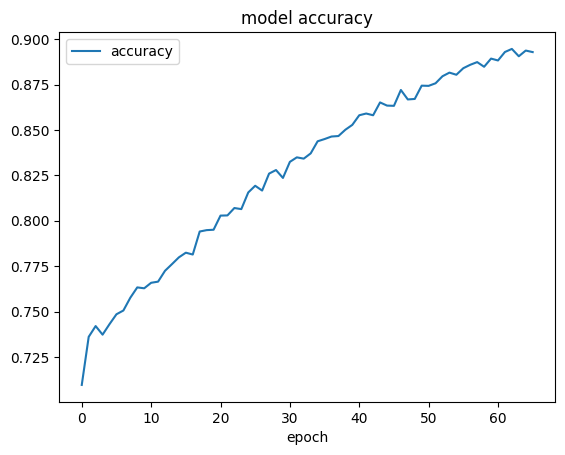

In [109]:
import matplotlib.pyplot as plt
# plt.plot(m.history['loss'])
plt.plot(m.history['accuracy'])
plt.title('model accuracy')
# plt.ylabel('loss')
plt.xlabel('epoch')
# plt.legend(['loss','accuracy'], loc='upper right')
plt.legend(['accuracy'], loc='upper left')
plt.show()

In [110]:
print("Inference:")
from keras.models import load_model
model = load_model("weights_best_t4.hdf5")

Inference:


In [111]:
# Plotting ROC curve to determine the threshold
def plot_roc_curve(fpr, tpr, label = None):
    plt.plot(fpr, tpr, linewidth=2, label = label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=11)
    plt.ylabel('True Positive Rate (Recall)', fontsize=11)
    plt.grid(True)

287/287 [==============================] - 2s 4ms/step
AUC = 0.7224


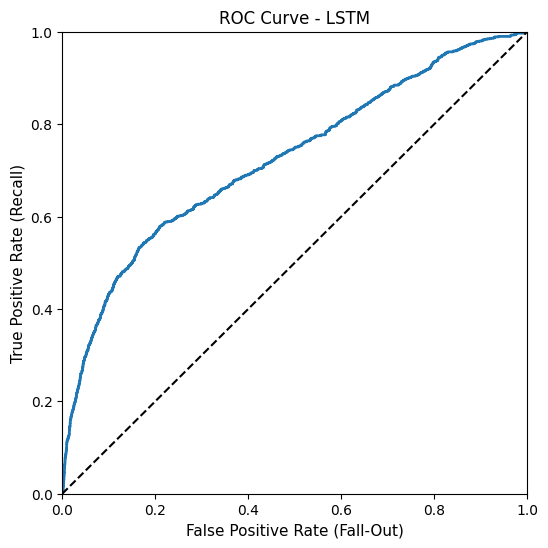

In [112]:
# Predict the test set using the best random forest regressor
y_pred = model.predict(x_test)

# Plotting ROC curve
fpr_rf_test, tpr_rf_test, thresholds_roc_rf_test = roc_curve(np.argmax(y_test, axis=1), y_pred[:, 1], pos_label=1)
# fpr_rf_test, tpr_rf_test, thresholds_roc_rf_test = roc_curve(y_test, y_pred, pos_label=1)
auc_t0_rf = auc(fpr_rf_test, tpr_rf_test)
print("AUC = {:.4f}".format(auc_t0_rf))

plt.figure(figsize=(6, 6))
plot_roc_curve(fpr_rf_test, tpr_rf_test)
plt.title("ROC Curve - LSTM")
plt.grid(False)
plt.show()

In [113]:
def print_results(M, X_train, Y_train, X_test, Y_test, threshold=0.5):
    Y_train = np.argmax(Y_train, axis=1)
    Y_test = np.argmax(Y_test, axis=1)

    preds_train = M.predict(X_train)
    preds_train = np.argmax(preds_train, axis=1)
    preds_train = [0 if x < threshold else 1 for x in preds_train]
    conf_mat_train = confusion_matrix(Y_train, preds_train)
    # conf_mat = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]

    preds_test = M.predict(X_test)
    preds_test = np.argmax(preds_test, axis=1)
    preds_test = [0 if x < threshold else 1 for x in preds_test]
    conf_mat_test = confusion_matrix(Y_test, preds_test)
    # conf_mat = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]

    print("***[RESULT]*** ACT  Confusion Matrix")
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))

    x_labels = ["Predicted\nNon-Sepsis", "Predicted\nSepsis"]
    y_labels = ["Actual Non-Sepsis", "Actual Sepsis"]
    sns.heatmap(conf_mat_train, fmt='d', annot=True, xticklabels=x_labels, yticklabels=y_labels, ax=axes[0])
    sns.heatmap(conf_mat_test, fmt='d', annot=True, xticklabels=x_labels, yticklabels=y_labels, ax=axes[1])

    axes[0].set_title("CM in training set", fontsize = 10)
    axes[1].set_title("CM in test set", fontsize = 10)
    axes[0].tick_params(labelsize=9)
    axes[1].tick_params(labelsize=9)
    plt.tight_layout()
    plt.show()

    f1_train = f1_score(Y_train, preds_train)
    f1_test = f1_score(Y_test, preds_test)
    acc_train = balanced_accuracy_score(Y_train, preds_train)
    acc_test = balanced_accuracy_score(Y_test, preds_test)
    # Computing precision and recall
    precision_train = precision_score(Y_train, preds_train)
    precision_test = precision_score(Y_test, preds_test)
    recall_train = recall_score(Y_train, preds_train)
    recall_test = recall_score(Y_test, preds_test)
    # table = pd.DataFrame({'F1-Score':[f1_train, f1_test], 'Balanced Acc':[acc_train, acc_test],
    #                      'Precision':[precision_train, precision_test], 'Recall':[recall_train, recall_test]},
    #                      index=['Train', 'Test'])

    table = pd.DataFrame({'Train':[acc_train, precision_train, recall_train, f1_train], 'Test':[acc_test, precision_test, recall_test, f1_test]},
                         index=['Balanced Acc', 'Precision', 'Recall', 'F1-Score'])
    print(table)

287/287 [==============================] - 1s 4ms/step
***[RESULT]*** ACT  Confusion Matrix


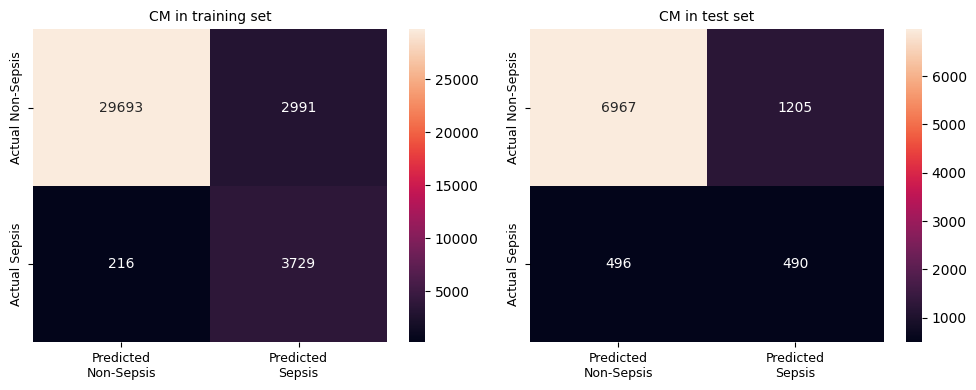

                 Train      Test
Balanced Acc  0.926867  0.674751
Precision     0.554911  0.289086
Recall        0.945247  0.496957
F1-Score      0.699297  0.365535


In [114]:
print_results(model, x_train, y_train, x_test, y_test) # 0.5

# Data Preparation - Train val test split

In [3]:
# t0_df = pd.read_csv(df_final)
path_df = ROOT_DIR / 'data/Model input data/t4_nan.csv'
df_data = pd.read_csv(path_df)# t0_df

admission = df_data[['SUBJECT_ID', 'HADM_ID', 'IS_SEPSIS']].drop_duplicates(["SUBJECT_ID", "HADM_ID"])

def df_split(X, Y, test_size):
    x_train, x_test, y_train, y_test = train_test_split(
        X,  # dropping the target column for X values
        Y,
        test_size=test_size,  # this means 20% test set
        stratify=Y,  # stratify by the target variable
        random_state=42  # to ensure reproducibility
        )
    return x_train, x_test, y_train, y_test

def create_data_df(data_df):
    x_train_df = df_data.merge(data_df[['SUBJECT_ID', 'HADM_ID']])
    x_train_df['count'] = x_train_df.groupby(['SUBJECT_ID', 'HADM_ID'])['HADM_ID'].transform('count')
    x_train_count = x_train_df.drop_duplicates(['SUBJECT_ID', 'HADM_ID'])['count']
    y_train_df = x_train_df.drop_duplicates(['SUBJECT_ID', 'HADM_ID'])['IS_SEPSIS']
    return x_train_df, x_train_count, y_train_df

x_train_df, x_test_df, y_train_df, _ = df_split(
                                                        admission.drop('IS_SEPSIS', axis=1),  # dropping the target column for X values
                                                        admission['IS_SEPSIS'],
                                                        test_size=0.2,
                                                        )

x_train_df, x_val_df, _, _ = df_split(
                                                x_train_df,  # dropping the target column for X values
                                                y_train_df,
                                                test_size=0.15,
                                                )

x_train_df, x_train_count, y_train_df = create_data_df(x_train_df)
x_test_df, x_test_count, y_test_df = create_data_df(x_test_df)
x_val_df, x_val_count, y_val_df = create_data_df(x_val_df)

In [4]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean', missing_values=np.nan)

train_gendernum = x_train_df.GENDER_NUM.values #take out the column doesn't need to scale
test_gendernum = x_test_df.GENDER_NUM.values
val_gendernum = x_val_df.GENDER_NUM.values

# impute X
x_train = imputer.fit_transform(x_train_df.drop(["SUBJECT_ID", "HADM_ID", 'IS_SEPSIS', 'CHARTTIME', 'count', 'GENDER_NUM'], axis=1))
x_test = imputer.transform(x_test_df.drop(["SUBJECT_ID", "HADM_ID", 'IS_SEPSIS', 'CHARTTIME', 'count', 'GENDER_NUM'], axis=1))
x_val = imputer.transform(x_val_df.drop(["SUBJECT_ID", "HADM_ID", 'IS_SEPSIS', 'CHARTTIME', 'count', 'GENDER_NUM'], axis=1))

In [5]:
# Feature scaling - Standardisation
scaler = StandardScaler()

x_train = scaler.fit_transform(x_train) #scale X
x_test = scaler.transform(x_test)
x_val = scaler.transform(x_val)

x_train = np.column_stack((x_train, train_gendernum)) #merge the columns doesn't need to scale back to X
x_test = np.column_stack((x_test, test_gendernum))
x_val = np.column_stack((x_val, val_gendernum))

In [6]:
def ts_to_secs(X, X_count, Y):
    secs_data = []

    k=0
    for i in X_count:
        secs_data.append(X[k:k+i, :])
        k = k+i

    secs_data = tf.ragged.constant(secs_data)

    # act_secs_labels = Y.values
    # act_secs_labels = np.array(act_secs_labels)
    act_secs_labels = to_categorical(Y)
    return secs_data, act_secs_labels


In [7]:
def data_preparation():
  train_data, act_train = ts_to_secs(x_train, x_train_count, y_train_df)
  test_data, act_test = ts_to_secs(x_test, x_test_count, y_test_df)
  val_data, act_val = ts_to_secs(x_val, x_val_count, y_val_df)

  # Here we add an extra dimension to the datasets just to be ready for using with Convolution2D
  print("[INFO] -- Shape of Training Sections:")
  print(train_data.bounding_shape())
  print("[INFO] -- Shape of Test Sections:")
  print(test_data.bounding_shape())
  print("[INFO] -- Shape of Validation Sections:")
  print(val_data.bounding_shape())

  return train_data, act_train, test_data, act_test, val_data, act_val

In [8]:
x_train, y_train, x_test, y_test, x_val, y_val = data_preparation()

[INFO] -- Shape of Training Sections:
tf.Tensor([31400    13    32], shape=(3,), dtype=int64)
[INFO] -- Shape of Test Sections:
tf.Tensor([9236   13   32], shape=(3,), dtype=int64)
[INFO] -- Shape of Validation Sections:
tf.Tensor([5542   12   32], shape=(3,), dtype=int64)


# Model Training with Accuracy

In [40]:
from keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import LSTM, Embedding, Input, MaxPooling2D
from keras.models import Sequential, Model
from sklearn.model_selection import  train_test_split
import time
import keras
import numpy as np

from keras.models import Sequential
def LSTM_model():
    feat_no = x_train[0][0].shape[0]
    d = 0.25
    model=Sequential()
    model.add(Input(shape=[None, feat_no], dtype=tf.float32, ragged=True))
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(d))
    model.add(LSTM(64,return_sequences=True))
    model.add(Dropout(d))
    model.add(LSTM(32))
    model.add(Dropout(d))
    model.add(Dense(25, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))

    return model

model = LSTM_model()
model.summary()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, None, 128)         82432     
                                                                 
 dropout_12 (Dropout)        (None, None, 128)         0         
                                                                 
 lstm_10 (LSTM)              (None, None, 64)          49408     
                                                                 
 dropout_13 (Dropout)        (None, None, 64)          0         
                                                                 
 lstm_11 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_14 (Dropout)        (None, 32)                0         
                                                                 
 dense_6 (Dense)             (None, 25)               

In [55]:
import model_evaluation as me
reload(me)

me.get_class_weights(y_train_df)

sample_weights = me.compute_sample_weights(y_train[:,1].astype(int))
# sample_weights = compute_sample_weights(y_train.astype(int))

sample_weights_test = me.compute_sample_weights(y_test[:,1].astype(int))
# sample_weights_test = compute_sample_weights(y_test.astype(int))

{0: 1.1207, 1: 9.2872}

In [39]:
from keras.optimizers import schedules
from keras.callbacks import LearningRateScheduler

def step_decay(epoch):
    initial_lr = 0.01  # Initial learning rate
    drop_rate = 0.25   # Learning rate drop factor
    epochs_drop = 5  # Number of epochs after which to drop the learning rate
    new_lr = initial_lr * (drop_rate ** (epoch // epochs_drop))
    return new_lr

lr_scheduler = LearningRateScheduler(step_decay)

In [ ]:
y_train.dtype

dtype('float32')

In [13]:
checkpointer = ModelCheckpoint(filepath = 'weights_best_t4.hdf5', save_best_only = True, monitor='val_accuracy', mode='max')
early_stop = keras.callbacks.EarlyStopping(monitor = 'val_accuracy', mode = 'max', patience = 5, restore_best_weights=True)
callbacks_list = [early_stop, checkpointer, lr_scheduler]
m = model.fit(x_train,y_train,
              sample_weight=sample_weights,
              epochs=40, batch_size=64, verbose=1,
              validation_data=(x_val, y_val),
               callbacks=callbacks_list)

Epoch 1/40
491/491 [==============================] - 13s 18ms/step - loss: 0.5905 - accuracy: 0.7255 - val_loss: 0.5091 - val_accuracy: 0.7279 - lr: 0.0100
Epoch 2/40
  1/491 [..............................] - ETA: 55s - loss: 0.5501 - accuracy: 0.7344

d:\Kha\UWA\CITS5553\sepsis_prediction\data-science-capstone-project\.venv\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


491/491 [==============================] - 9s 19ms/step - loss: 0.5468 - accuracy: 0.7453 - val_loss: 0.4497 - val_accuracy: 0.7716 - lr: 0.0100
Epoch 3/40
491/491 [==============================] - 10s 20ms/step - loss: 0.5325 - accuracy: 0.7534 - val_loss: 0.4934 - val_accuracy: 0.7474 - lr: 0.0100
Epoch 4/40
491/491 [==============================] - 10s 20ms/step - loss: 0.5208 - accuracy: 0.7563 - val_loss: 0.4916 - val_accuracy: 0.7108 - lr: 0.0100
Epoch 5/40
491/491 [==============================] - 10s 20ms/step - loss: 0.5123 - accuracy: 0.7496 - val_loss: 0.4794 - val_accuracy: 0.7025 - lr: 0.0100
Epoch 6/40
491/491 [==============================] - 10s 20ms/step - loss: 0.4728 - accuracy: 0.7709 - val_loss: 0.4801 - val_accuracy: 0.7687 - lr: 0.0050
Epoch 7/40
491/491 [==============================] - 10s 21ms/step - loss: 0.4446 - accuracy: 0.7894 - val_loss: 0.4662 - val_accuracy: 0.7860 - lr: 0.0050
Epoch 8/40
491/491 [==============================] - 10s 21ms/step - 

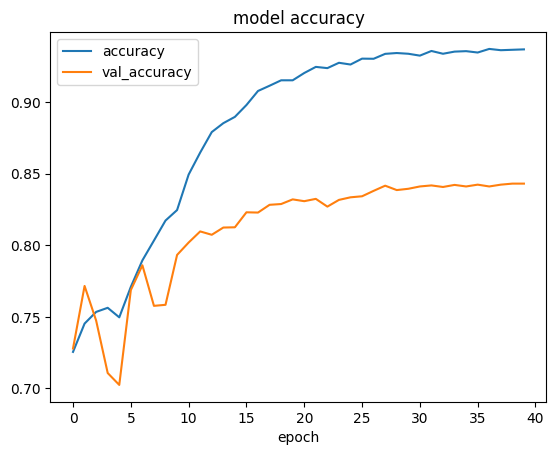

In [14]:
import matplotlib.pyplot as plt
# plt.plot(m.history['loss'])
plt.plot(m.history['accuracy'])
plt.plot(m.history['val_accuracy'])
plt.title('model accuracy')
# plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy'], loc='upper left')
plt.show()

In [53]:
print("Inference:")
from keras.models import load_model
model = load_model("weights_best_t4.hdf5")
model.optimizer.lr.numpy()

Inference:


289/289 [==============================] - 2s 4ms/step
AUC = 0.7119


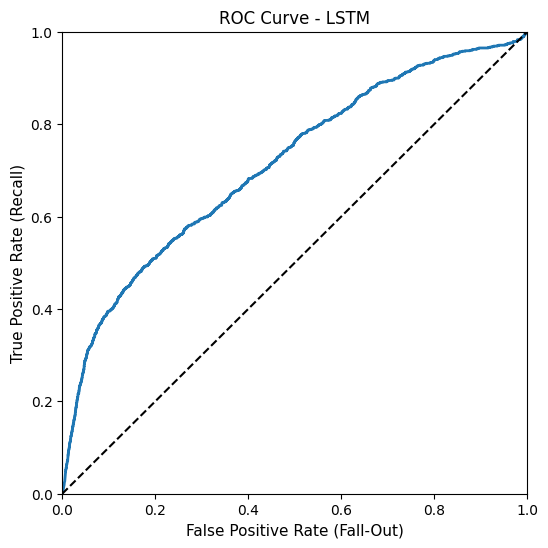

In [58]:
me.plot_auc_roc_curve(model, x_test, y_test)

289/289 [==============================] - 1s 4ms/step
***[RESULT]*** ACT  Confusion Matrix


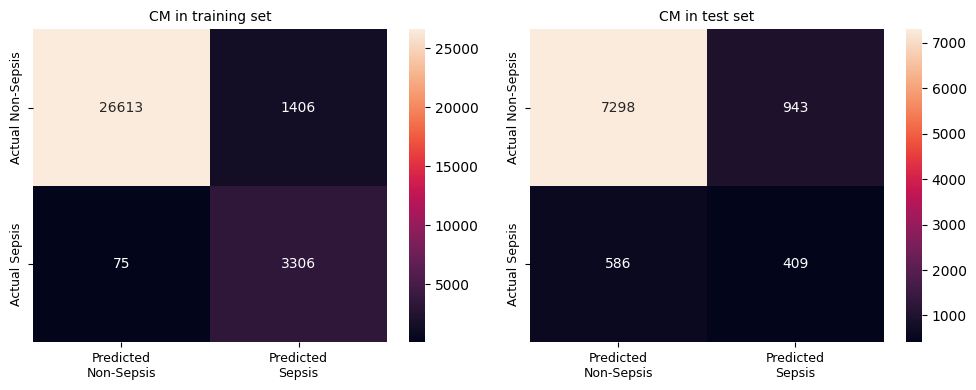

                 Train      Test
Balanced Acc  0.963818  0.648314
Precision     0.701613  0.302515
Recall        0.977817  0.411055
F1-Score      0.817002  0.348530


In [59]:
me.print_results(model, x_train, y_train, x_test, y_test)

# Model training with AUC - dropout rate = 0.5

In [18]:
import keras

METRICS = [
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.AUC(name='auc'),
]

In [22]:
from keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import LSTM, Embedding, Input, MaxPooling2D
from keras.models import Sequential, Model
from sklearn.model_selection import  train_test_split
import time
import keras
import numpy as np

from keras.models import Sequential
def LSTM_model():
    feat_no = x_train[0][0].shape[0]
    d = 0.5
    model=Sequential()
    model.add(Input(shape=[None, feat_no], dtype=tf.float32, ragged=True))
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(d))
    model.add(LSTM(64,return_sequences=True))
    model.add(Dropout(d))
    model.add(LSTM(32))
    model.add(Dropout(d))
    model.add(Dense(25, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))

    return model

model = LSTM_model()
model.summary()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics = METRICS)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, None, 128)         82432     
                                                                 
 dropout_12 (Dropout)        (None, None, 128)         0         
                                                                 
 lstm_10 (LSTM)              (None, None, 64)          49408     
                                                                 
 dropout_13 (Dropout)        (None, None, 64)          0         
                                                                 
 lstm_11 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_14 (Dropout)        (None, 32)                0         
                                                                 
 dense_6 (Dense)             (None, 25)               

In [13]:
import model_evaluation as me
reload(me)

me.get_class_weights(y_train_df)

sample_weights = me.compute_sample_weights(y_train[:,1].astype(int))
# sample_weights = compute_sample_weights(y_train.astype(int))

sample_weights_test = me.compute_sample_weights(y_test[:,1].astype(int))
# sample_weights_test = compute_sample_weights(y_test.astype(int))

{0: 1.1207, 1: 9.2872}

In [15]:
from keras.optimizers import schedules
from keras.callbacks import LearningRateScheduler

def step_decay(epoch):
    initial_lr = 0.01  # Initial learning rate
    drop_rate = 0.25   # Learning rate drop factor
    epochs_drop = 5  # Number of epochs after which to drop the learning rate
    new_lr = initial_lr * (drop_rate ** (epoch // epochs_drop))
    return new_lr

lr_scheduler = LearningRateScheduler(step_decay)

In [23]:
checkpointer = ModelCheckpoint(filepath = 'weights_best_t4_binacc_.hdf5', save_best_only = True, monitor='val_auc', mode='max')
early_stop = keras.callbacks.EarlyStopping(monitor = 'val_auc', mode = 'max', patience = 5, restore_best_weights=True)
callbacks_list = [early_stop, checkpointer, lr_scheduler]
m = model.fit(x_train,y_train,
              sample_weight=sample_weights,
              epochs=40, batch_size=64, verbose=1,
              validation_data=(x_val, y_val),
               callbacks=callbacks_list)

Epoch 1/40


491/491 [==============================] - 14s 19ms/step - loss: 0.5910 - accuracy: 0.7248 - auc: 0.7762 - val_loss: 0.5042 - val_accuracy: 0.7237 - val_auc: 0.8267 - lr: 0.0100
Epoch 2/40
491/491 [==============================] - 9s 18ms/step - loss: 0.5596 - accuracy: 0.7320 - auc: 0.7952 - val_loss: 0.5371 - val_accuracy: 0.7236 - val_auc: 0.8060 - lr: 0.0100
Epoch 3/40
491/491 [==============================] - 9s 18ms/step - loss: 0.5435 - accuracy: 0.7382 - auc: 0.8078 - val_loss: 0.4804 - val_accuracy: 0.7431 - val_auc: 0.8435 - lr: 0.0100
Epoch 4/40
491/491 [==============================] - 9s 18ms/step - loss: 0.5396 - accuracy: 0.7350 - auc: 0.8077 - val_loss: 0.4631 - val_accuracy: 0.7266 - val_auc: 0.8440 - lr: 0.0100
Epoch 5/40
491/491 [==============================] - 10s 21ms/step - loss: 0.5377 - accuracy: 0.7413 - auc: 0.8092 - val_loss: 0.4854 - val_accuracy: 0.7615 - val_auc: 0.8500 - lr: 0.0100
Epoch 6/40
491/491 [==============================] - 10s 21ms/step -

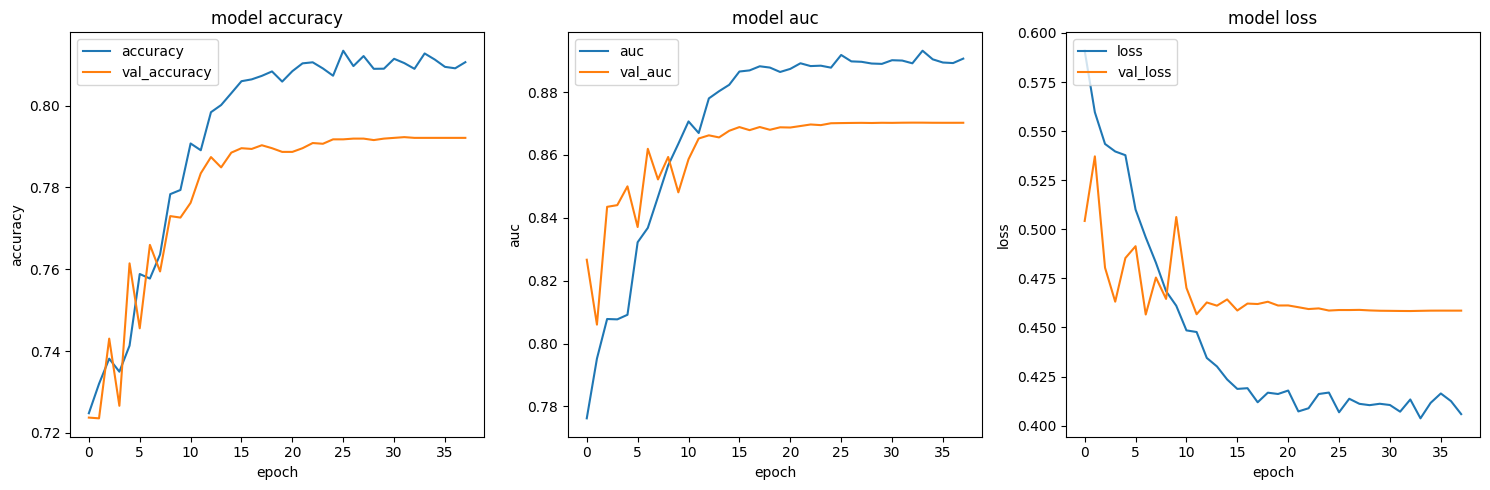

In [41]:
import matplotlib.pyplot as plt

# Create a figure with two subplots side by side
fig, (plt1, plt2, plt3) = plt.subplots(1, 3, figsize=(15, 5))

# plt.plot(m.history['loss'])
plt1.plot(m.history['accuracy'])
plt1.plot(m.history['val_accuracy'])
plt1.set_title('model accuracy')
plt1.set_ylabel('accuracy')
plt1.set_xlabel('epoch')
plt1.legend(['accuracy', 'val_accuracy'], loc='upper left')

# plt.plot(m.history['loss'])
plt2.plot(m.history['auc'])
plt2.plot(m.history['val_auc'])
plt2.set_title('model auc')
plt2.set_ylabel('auc')
plt2.set_xlabel('epoch')
plt2.legend(['auc', 'val_auc'], loc='upper left')

# plt.plot(m.history['loss'])
plt3.plot(m.history['loss'])
plt3.plot(m.history['val_loss'])
plt3.set_title('model loss')
plt3.set_ylabel('loss')
plt3.set_xlabel('epoch')
plt3.legend(['loss', 'val_loss'], loc='upper left')

plt.tight_layout()
plt.show()

In [60]:
print("Inference:")
from keras.models import load_model
model = load_model("weights_best_t4_binacc_.hdf5")
model.optimizer.lr.numpy()

Inference:


2.4414062e-06

289/289 [==============================] - 2s 4ms/step
AUC = 0.7951


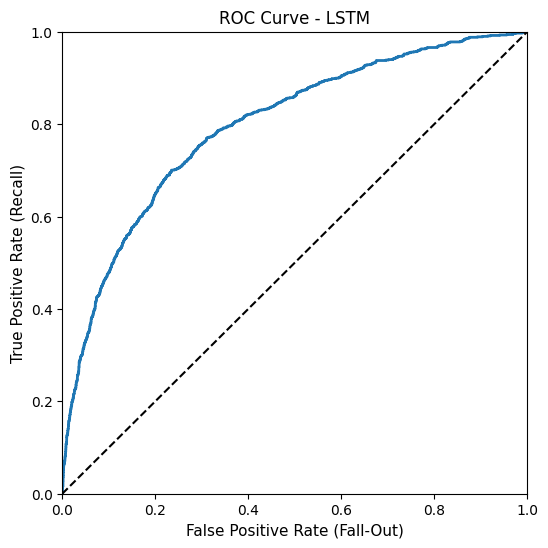

In [43]:
me.plot_auc_roc_curve(model, x_test, y_test)

289/289 [==============================] - 1s 4ms/step
***[RESULT]*** ACT  Confusion Matrix


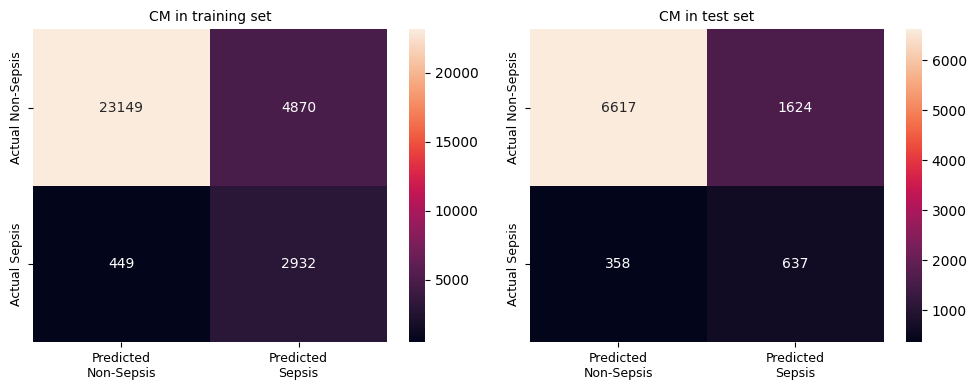

                 Train      Test
Balanced Acc  0.846694  0.721569
Precision     0.375801  0.281734
Recall        0.867199  0.640201
F1-Score      0.524367  0.391278


In [44]:
me.print_results(model, x_train, y_train, x_test, y_test)

# Model Training

In [ ]:
import keras

METRICS = [
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.AUC(name='auc'),
]

In [64]:
from keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import LSTM, Embedding, Input, MaxPooling2D
from keras.models import Sequential, Model
from sklearn.model_selection import  train_test_split
import time
import keras
import numpy as np

from keras.models import Sequential
def LSTM_model():
    feat_no = x_train[0][0].shape[0]
    d = 0.5
    model=Sequential()
    model.add(Input(shape=[None, feat_no], dtype=tf.float32, ragged=True))
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(d))
    model.add(LSTM(64,return_sequences=True))
    model.add(Dropout(d))
    model.add(LSTM(32))
    model.add(Dropout(d))
    model.add(Dense(25, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='sigmoid'))

    return model

model = LSTM_model()
model.summary()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics = METRICS)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, None, 128)         82432     
                                                                 
 dropout_20 (Dropout)        (None, None, 128)         0         
                                                                 
 lstm_16 (LSTM)              (None, None, 64)          49408     
                                                                 
 dropout_21 (Dropout)        (None, None, 64)          0         
                                                                 
 lstm_17 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_22 (Dropout)        (None, 32)                0         
                                                                 
 dense_10 (Dense)            (None, 25)               

In [72]:
import model_evaluation as me
reload(me)

me.get_class_weights(y_train_df)

sample_weights = me.compute_sample_weights(y_train[:,1].astype(int))
# sample_weights = compute_sample_weights(y_train.astype(int))

sample_weights_test = me.compute_sample_weights(y_test[:,1].astype(int))
# sample_weights_test = compute_sample_weights(y_test.astype(int))

In [38]:
tf.math.exp(-0.1)

<tf.Tensor: shape=(), dtype=float32, numpy=0.9048374>

In [61]:
from keras.optimizers import schedules
from keras.callbacks import LearningRateScheduler

# def step_decay(epoch):
#     initial_lr = 0.01  # Initial learning rate
#     drop_rate = 0.25   # Learning rate drop factor
#     epochs_drop = 5  # Number of epochs after which to drop the learning rate
#     new_lr = initial_lr * (drop_rate ** (epoch // epochs_drop))
#     return new_lr

# lr_scheduler = LearningRateScheduler(step_decay)

def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
    
lr_scheduler = LearningRateScheduler(scheduler)

In [65]:
checkpointer = ModelCheckpoint(filepath = 'weights_best_t4_binacc_2.hdf5', save_best_only = True, monitor='val_auc', mode='max')
early_stop = keras.callbacks.EarlyStopping(monitor = 'val_auc', mode = 'max', patience = 5, restore_best_weights=True)
callbacks_list = [lr_scheduler, early_stop, checkpointer]
m = model.fit(x_train,y_train,
              sample_weight=sample_weights,
              epochs=40, batch_size=64, verbose=1,
              validation_data=(x_val, y_val),
               callbacks=callbacks_list)

Epoch 1/40
491/491 [==============================] - 15s 21ms/step - loss: 0.6026 - accuracy: 0.6828 - auc: 0.7418 - val_loss: 0.5689 - val_accuracy: 0.7201 - val_auc: 0.7793 - lr: 0.0010
Epoch 2/40
491/491 [==============================] - 10s 19ms/step - loss: 0.5387 - accuracy: 0.7474 - auc: 0.8088 - val_loss: 0.5218 - val_accuracy: 0.7185 - val_auc: 0.8163 - lr: 0.0010
Epoch 3/40
491/491 [==============================] - 11s 22ms/step - loss: 0.5234 - accuracy: 0.7397 - auc: 0.8148 - val_loss: 0.4985 - val_accuracy: 0.7373 - val_auc: 0.8357 - lr: 0.0010
Epoch 4/40
491/491 [==============================] - 11s 22ms/step - loss: 0.5137 - accuracy: 0.7450 - auc: 0.8260 - val_loss: 0.4651 - val_accuracy: 0.7612 - val_auc: 0.8606 - lr: 0.0010
Epoch 5/40
491/491 [==============================] - 11s 22ms/step - loss: 0.5046 - accuracy: 0.7453 - auc: 0.8309 - val_loss: 0.5209 - val_accuracy: 0.7454 - val_auc: 0.8243 - lr: 0.0010
Epoch 6/40
491/491 [==============================] - 1

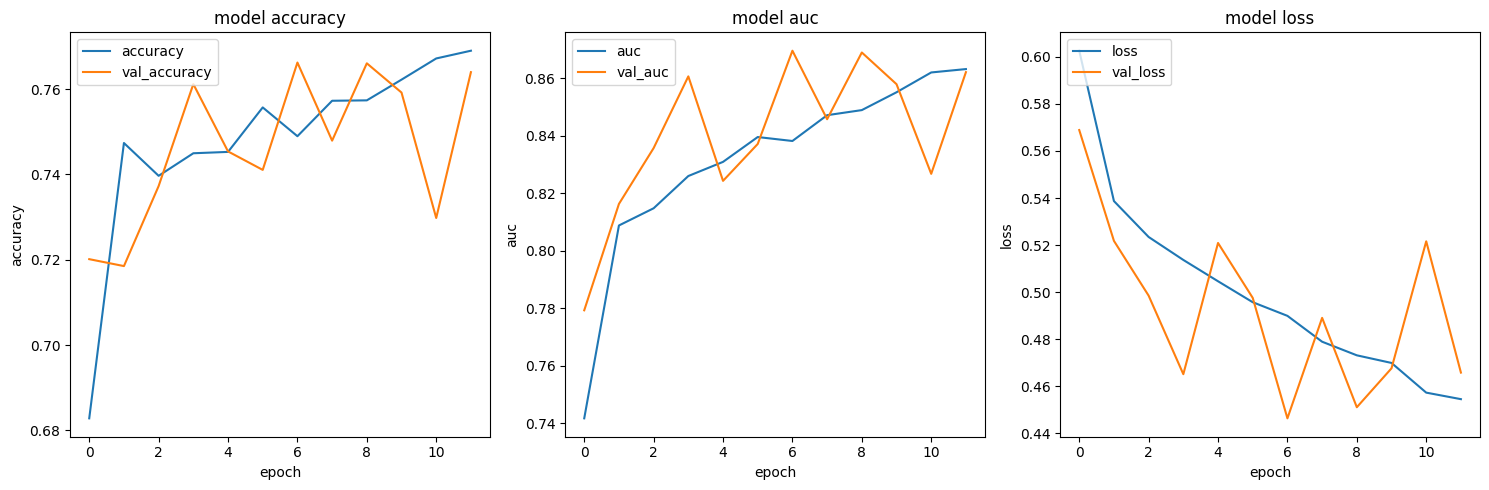

In [66]:
import matplotlib.pyplot as plt

# Create a figure with two subplots side by side
fig, (plt1, plt2, plt3) = plt.subplots(1, 3, figsize=(15, 5))

# plt.plot(m.history['loss'])
plt1.plot(m.history['accuracy'])
plt1.plot(m.history['val_accuracy'])
plt1.set_title('model accuracy')
plt1.set_ylabel('accuracy')
plt1.set_xlabel('epoch')
plt1.legend(['accuracy', 'val_accuracy'], loc='upper left')

# plt.plot(m.history['loss'])
plt2.plot(m.history['auc'])
plt2.plot(m.history['val_auc'])
plt2.set_title('model auc')
plt2.set_ylabel('auc')
plt2.set_xlabel('epoch')
plt2.legend(['auc', 'val_auc'], loc='upper left')

# plt.plot(m.history['loss'])
plt3.plot(m.history['loss'])
plt3.plot(m.history['val_loss'])
plt3.set_title('model loss')
plt3.set_ylabel('loss')
plt3.set_xlabel('epoch')
plt3.legend(['loss', 'val_loss'], loc='upper left')

plt.tight_layout()
plt.show()

In [67]:
print("Inference:")
from keras.models import load_model
model = load_model("weights_best_t4_binacc_2.hdf5")
model.optimizer.lr.numpy()

Inference:


0.0008187308

  1/289 [..............................] - ETA: 6s

289/289 [==============================] - 2s 7ms/step
AUC = 0.8181


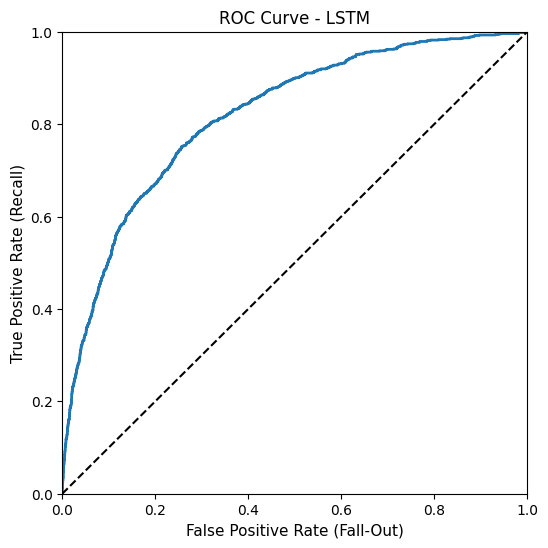

In [79]:
me.plot_auc_roc_curve(model, x_test, y_test)

289/289 [==============================] - 2s 6ms/step
***[RESULT]*** ACT  Confusion Matrix


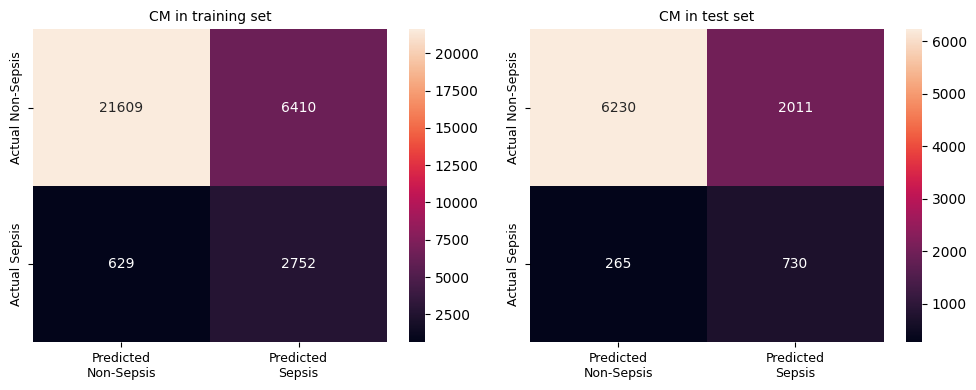

                 Train      Test
Balanced Acc  0.792594  0.744822
Precision     0.300371  0.266326
Recall        0.813960  0.733668
F1-Score      0.438810  0.390792


In [78]:
me.print_results(model, x_train, y_train, x_test, y_test)

# TimeSHAP

Model entry point

In [20]:
f = lambda x: model.predict(x)[:, 1]
raw_model_features = train_data_df.columns
model_features = [f"p_normalize_{x}" for x in np.delete(raw_model_features, [0,1,4])]

In [21]:
d_train_normalized = pd.concat([train_data_df, pd.DataFrame(x_train, columns=model_features)], axis=1)
d_test_normalized = pd.concat([test_data_df, pd.DataFrame(x_test, columns=model_features)], axis=1)

Baseline event

In [22]:
from timeshap.utils import calc_avg_event
average_event = calc_avg_event(d_train_normalized, numerical_feats=model_features, categorical_feats=[])

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [42]:
average_event

,p_AGE_normalize,p_GENDER_NUM_normalize,p_ITEMID_50804_normalize,p_ITEMID_50813_normalize,p_ITEMID_50818_normalize,p_ITEMID_50820_normalize,p_ITEMID_50821_normalize,p_ITEMID_50862_normalize,p_ITEMID_50863_normalize,p_ITEMID_50878_normalize,...,p_ITEMID_51244_normalize,p_ITEMID_51248_normalize,p_ITEMID_51256_normalize,p_ITEMID_51265_normalize,p_ITEMID_51274_normalize,p_ITEMID_51275_normalize,p_ITEMID_51277_normalize,p_ITEMID_51279_normalize,p_ITEMID_51301_normalize,p_ITEMID_51493_normalize
0,0.187396,-0.850357,-0.842224,-0.848199,-0.842027,-0.890172,-0.832588,-0.501391,-0.611267,-0.482339,...,-0.913225,0.713598,-0.91318,0.562068,0.887343,0.898833,0.715028,0.715364,0.702611,-0.298054


In [ ]:
from timeshap.utils import calc_avg_sequence
average_sequence = calc_avg_sequence(d_train_normalized, numerical_feats=model_features, categorical_feats=[],model_features=model_features, entity_col='HADM_ID')

Average score over baseline

In [23]:
print("Inference:")
from keras.models import load_model
model = load_model("weights_best_t4.hdf5")

Inference:


In [44]:
model.predict(test_data).shape

289/289 [==============================] - 2s 5ms/step


(9233, 2)

In [ ]:
from timeshap.utils import get_avg_score_with_avg_event
avg_score_over_len = get_avg_score_with_avg_event(f, average_event, top=480)

## Local Explanations

In [133]:
ids_for_test = [183628, 116009, 107064, 109235] # first 2 hadm_id are sepsis case, last 2 are non-sepsis
pos_x_pd = d_test_normalized[d_test_normalized['HADM_ID'].isin(ids_for_test)]
labels = d_test_normalized[d_test_normalized.HADM_ID.isin(ids_for_test)].drop_duplicates(['HADM_ID'])[['HADM_ID', 'IS_SEPSIS']]

# select model features only
# pos_x_data = pos_x_pd[model_features]
# convert the instance to numpy so TimeSHAP receives it
pos_x_data = [np.expand_dims(pos_x_pd[pos_x_pd.HADM_ID==x][model_features].to_numpy().copy(), axis=0) for x in ids_for_test]

In [25]:
_, df_desc_labitems,_ = dataLoader.load_descriptions()

In [26]:
plot_feats_1 = {x:x[12:] for x in model_features[:2]}
plot_feats_2 = {x: df_desc_labitems[df_desc_labitems.ITEMID == int(x[19:])].LABEL.values[0] for x in model_features[2:]}
plot_feats = {**plot_feats_1, **plot_feats_2}

In [130]:
from timeshap.explainer import local_report, local_pruning, local_feat
from timeshap.plot import plot_feat_barplot, plot_global_feat, feature_level
import altair  as alt
sequence_id_feat = 'HADM_ID'

def plot_local_features(ids_for_test, pos_x_data, labels):
  objects = len(ids_for_test)
  plots = []
  for pos_id in list(range(0,objects)):
    hadm_id = ids_for_test[pos_id]
    pos_x = pos_x_data[pos_id]
    label = 'SEPSIS' if labels[labels.HADM_ID == hadm_id]['IS_SEPSIS'].values==1 else 'NON-SEPSIS'
    pruning_dict = {'tol': 0.025,}
    coal_plot_data, coal_prun_idx = local_pruning(f, pos_x, pruning_dict, average_event, hadm_id, sequence_id_feat, False)
    # coal_prun_idx is in negative terms
    pruning_idx = pos_x.shape[1] + coal_prun_idx

    feature_dict = {'rs': 42, 'nsamples': 32000, 'feature_names': model_features, 'plot_features': plot_feats}
    feature_data = local_feat(f, pos_x, feature_dict, hadm_id, sequence_id_feat, average_event, pruning_idx)
    feat_plot_0 = plot_feat_barplot(feature_data, feature_dict.get('top_feats'), feature_dict.get('plot_features'))
    feat_plot_0 = feat_plot_0.properties(width=500, height = {'step': 15}, title=f'HADM_ID: {hadm_id}, {label}')
    feat_plot_0 = feat_plot_0.encode(
        x=alt.X('Shapley Value', type='quantitative', scale=alt.Scale(domain=[-0.5, 0.5]))
    )
    plots.append(feat_plot_0)
  return plots

In [134]:
feat_plots = plot_local_features(ids_for_test, pos_x_data, labels)

1000/1000 [==============================] - 2s 2ms/step


In [135]:
(feat_plots[0] | feat_plots[1]) & (feat_plots[2] | feat_plots[3])

alt.VConcatChart(...)

## Global Explanation

In [75]:
d_test_normalized['timestamp'] = d_test_normalized.groupby(['SUBJECT_ID', 'HADM_ID']).cumcount()
d_test_normalized.timestamp = d_test_normalized.timestamp.astype(int)

In [143]:
from timeshap.explainer import prune_all, pruning_statistics, event_explain_all, feat_explain_all
from timeshap.plot import plot_global_event, plot_global_feat

pos_dataset = d_test_normalized
schema = list(pos_dataset.columns)
time_feat = 'timestamp'

In [ ]:
pruning_dict = {'tol': [0.05, 0.075], 'path': 'outputs/prun_all_tf.csv'}
prun_indexes = prune_all(f, pos_dataset, pruning_dict, average_event, model_features, schema, sequence_id_feat, time_feat)
# pruning_stats = pruning_statistics(prun_indexes, pruning_dict.get('tol'))
# pruning_stats

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 26s 26s/step


In [78]:
# prun_indexes = pd.read_csv('prun_all_tf.csv')
prun_indexes

In [1]:
event_dict = {'rs': 42, 'nsamples': 32000}
event_data = event_explain_all(f, pos_dataset, event_dict, prun_indexes, average_event, model_features, schema, sequence_id_feat, time_feat)
event_global_plot = plot_global_event(event_data)
event_global_plot

NameError: ignored